In [1]:
from utils import set_working_directory_up_two_levels
set_working_directory_up_two_levels()

In [11]:
import tensorflow as tf
import pandas as pd 
import numpy as np
import toml 
import os

import matplotlib.pyplot as plt 
from src.data.record import DataPipeline
from presentation.pipelines.steps.model_design import load_pt_model, build_model
from presentation.pipelines.steps.load_data import build_loader 
from sklearn.metrics import r2_score, mean_squared_error
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [14]:
model = build_model(params={
'num_layers': 12,
'num_heads': 6,
'head_dim': 6,
'mixer': 1024,
'dropout': 0.1,
'pe_base': 1000,
'pe_dim': 256,
'pe_exp': 2,
'window_size': 300,
'm_alpha': 0,
'mask_format': 'K',
'use_leak': True,
'loss_format': 'rmse',
'correct_loss': True,
'no_msk_token': False,
'temperature': 0,
    'arch': 'base'
})

[INFO] Loading BASE
[INFO] Temperature: 0.00
[INFO] Mask format: K
[INFO] Adding trainable MSK token


In [15]:
model.summary()

Model: "ASTROMER-1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 300, 1)]             0         []                            
                                                                                                  
 input_11 (InputLayer)       [(None, 300, 1)]             0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 300, 1)]             0         []                            
                                                                                                  
 encoder (Encoder)           (None, 300, 36)              1027280   ['input_10[0][0]',            
                                                                     'input_11[0][0]',   

In [7]:
root = './presentation/results/diagstromer/2024-12-05_12-33-41/pretraining/'
model, config = load_pt_model(root)

[INFO] Loading BASE
[INFO] Temperature: 0.00
[INFO] Mask format: K
[INFO] Adding trainable MSK token


NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./presentation/results/diagstromer/2024-12-05_12-33-41/pretraining/weights

In [4]:
loaders = build_loader('./data/records/alcock/all/fold_2/', 
                       config, 
                       batch_size=16, 
                       clf_mode=False, 
                       normalize='zero-mean', 
                       sampling=False,
                       repeat=1,
                       shuffle=True,
                       cache=False,
                       return_test=True)

[INFO] String based loader
[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Normalization:  zero-mean
[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Normalization:  zero-mean
[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Normalization:  zero-mean


In [5]:
from astropy.timeseries import LombScargle

def fold_curve(times, magnitudes):
    frequency, power = LombScargle(times, magnitudes).autopower()
    period = 1/frequency[np.argmax(power)]
    phase = (times % period)/period
    indices = np.argsort(phase)
    return indices

(16, 200, 256)


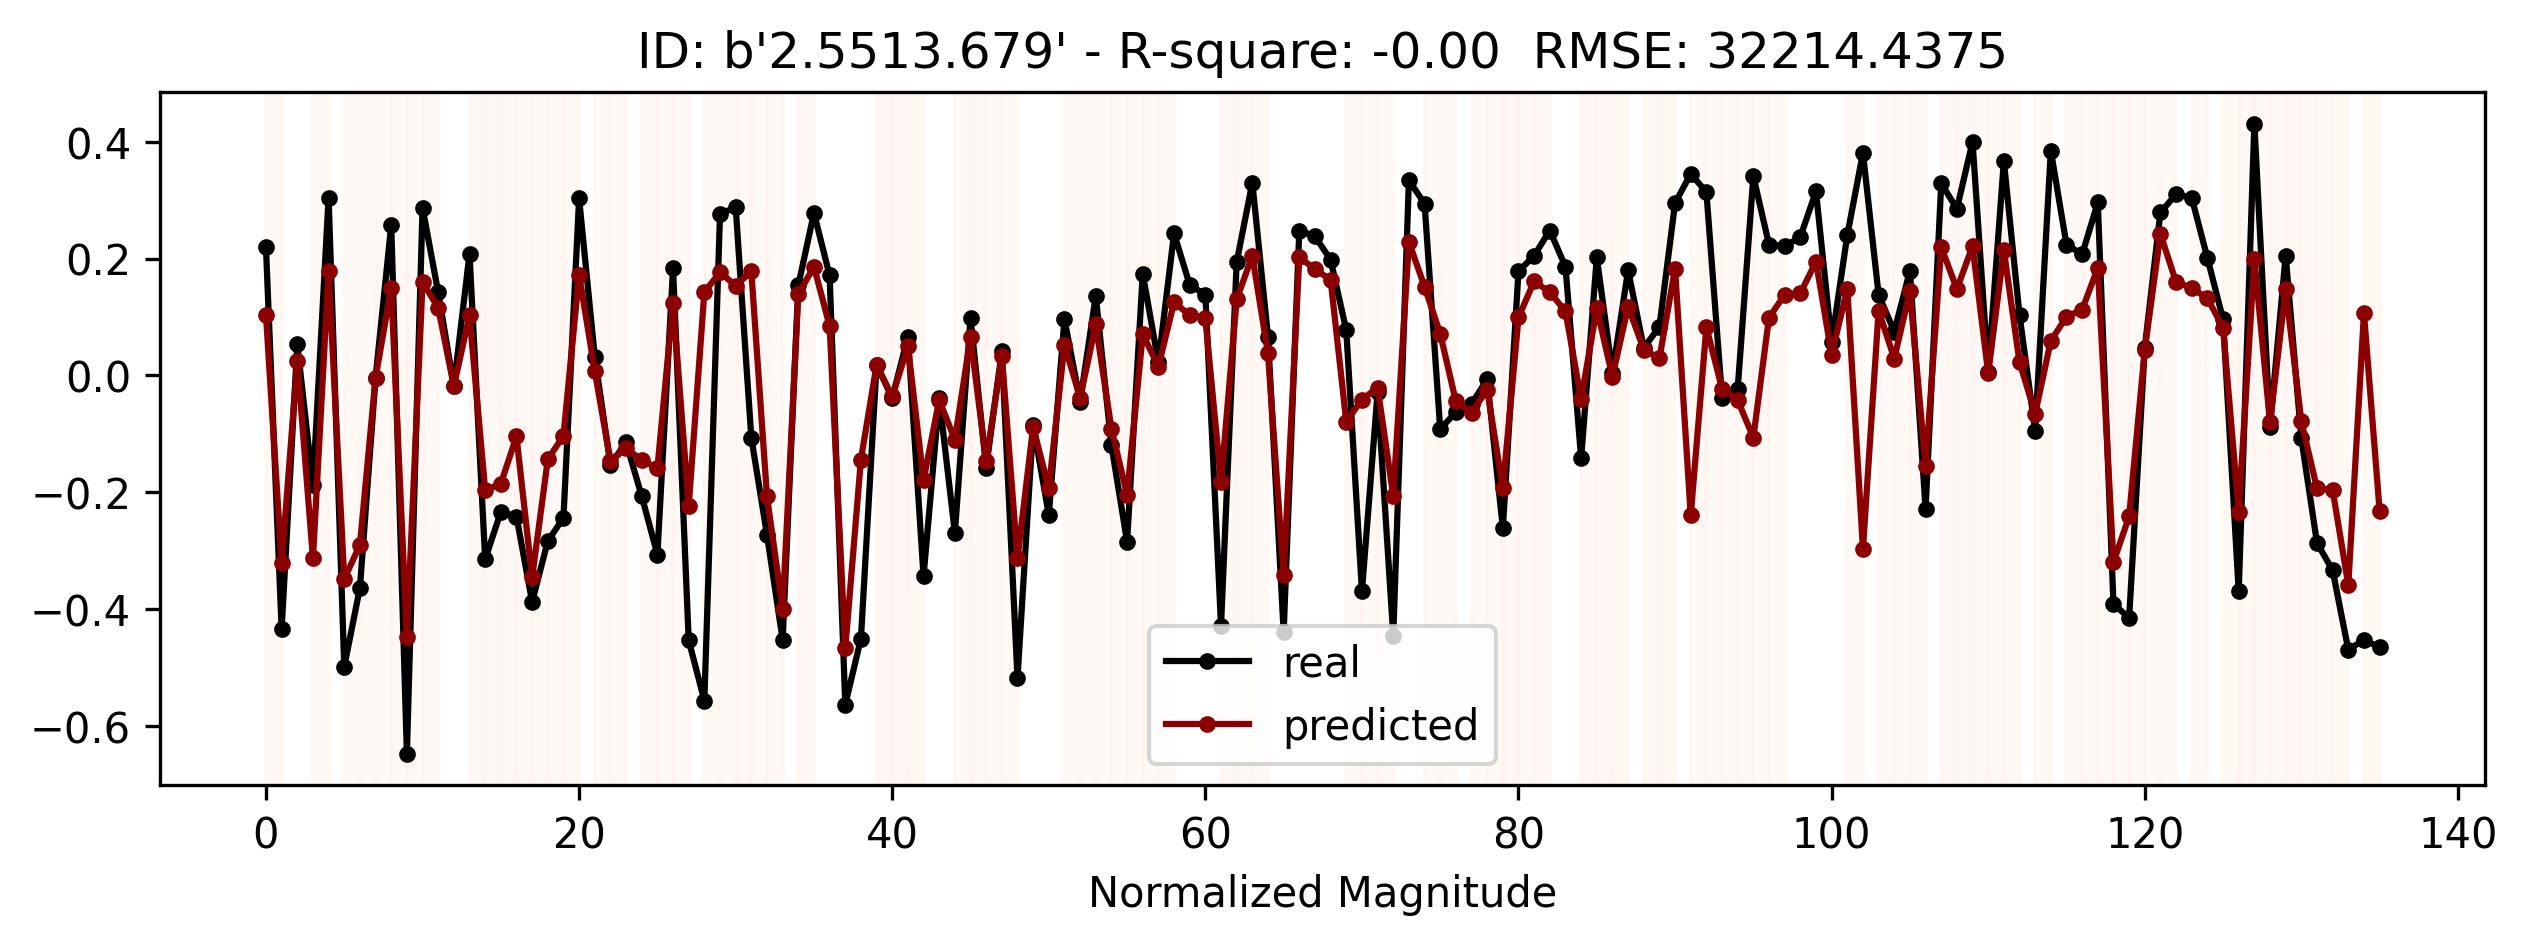

In [188]:
plt.figure(figsize=(10, 3), dpi=300)
for x, y in loaders['train'].take(1):
       
    y_pred = model(x)

    valid = y['target'][N] * x['mask_in'][N]
    
    
    
    r2value = r2_score(tmasked.numpy(), pmasked.numpy())
    msevalue = mean_squared_error(tmasked.numpy(), pmasked.numpy())
    
    indices = fold_curve(tmasked, xmasked)

    tmasked = tmasked.numpy()[indices]
    xmasked = xmasked.numpy()[indices]
    pmasked = pmasked.numpy()[indices]
    mean_attention = mean_attention[indices]

